In [ ]:
# load the necessary functions
for (fnm in list.files("/home/jovyan/shared_materials/rwwa", full.names = T)) source(fnm)
library(extRemes)

NB. If you want to find out more about how any R function works and what the required arguments are, try (for example)
`?merge`, eg.

In [ ]:
?merge

In [2]:
NA

[1] NA

# Load the data

Up-to-date GMST data can be downloaded from https://climexp.knmi.nl/data/igiss_al_gl_a_4yrlo.dat  
(Climate Explorer > Attribution runs > Smoothed GMST > raw data

In [ ]:
# load your annual time series & GMST
ts <- read.csv("ts_era5.csv", col.names = c("year", "tmax"))
gmst <- read.table("gmst.txt", col.names = c("year", "gmst"))

# merge time series with GMST covariate (matched by 'year' because this appears in both data.frames)
df <- merge(gmst, ts)

# adjust GMST to express as an anomaly with respect to your event year
df$gmst <- df$gmst - df$gmst[df$year == 2024]

# Fit the chosen linear model & define the factual / counterfactual climates

In general,
- `type` is `shift` for temperatures and `fixeddisp` for precipitation
- `dist` is `GEV` for annual maxima/minima; `norm` for monthly/seasonal average

If this doesn't fit your data well, let us know - there are ways to transform skewed data to be more Gaussian, for example

In [28]:
mdl <- fit_ns(dist = "gev", type = "shift", data = df, varnm = "tmax", covnm = "gmst", lower = F, ev_year = 2024)

# the factual climate should have the GMST of the year in which the event occurred
cov_factual <- data.frame(gmst = df$gmst[df$year == 2024])

# the counterfactual climate can represent any alternative climate (WWA always uses a preindustrial climate, 1.3C cooler than the present)
cov_counterfactual <- data.frame(gmst = df$gmst[df$year == 2024] - 1.3)

## Check that the model is a good fit to the data

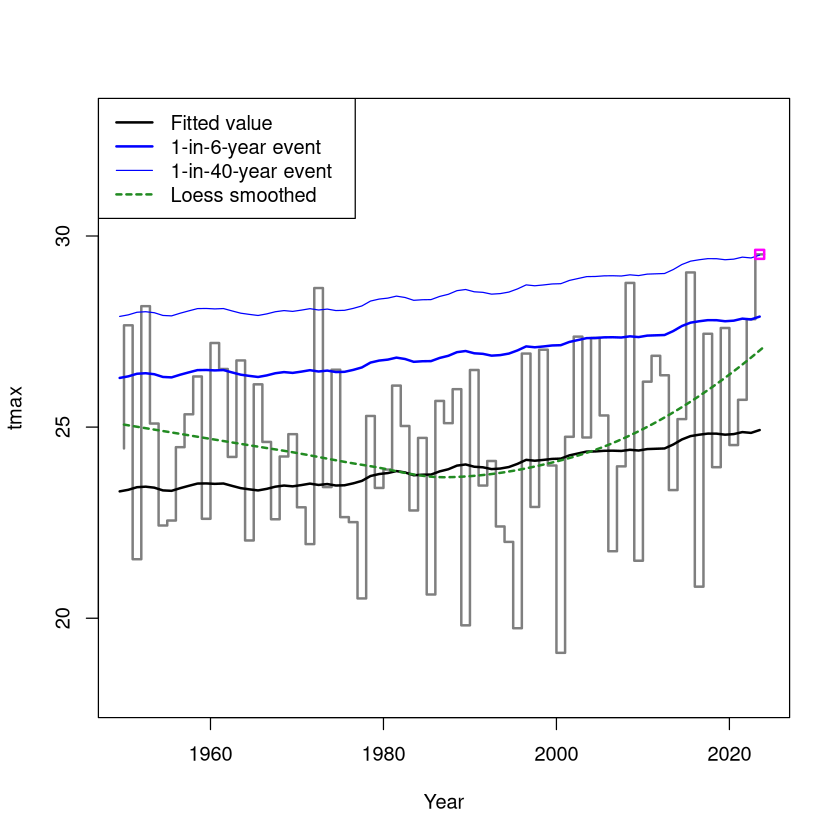

In [29]:
# what does the fitted trend look like over time?
# `add_loess = T` will add a nonparametric smoother - use this to check whether the fitted model captures the observed trend
plot_trend(mdl, add_loess = T, ylim = c(18,33))

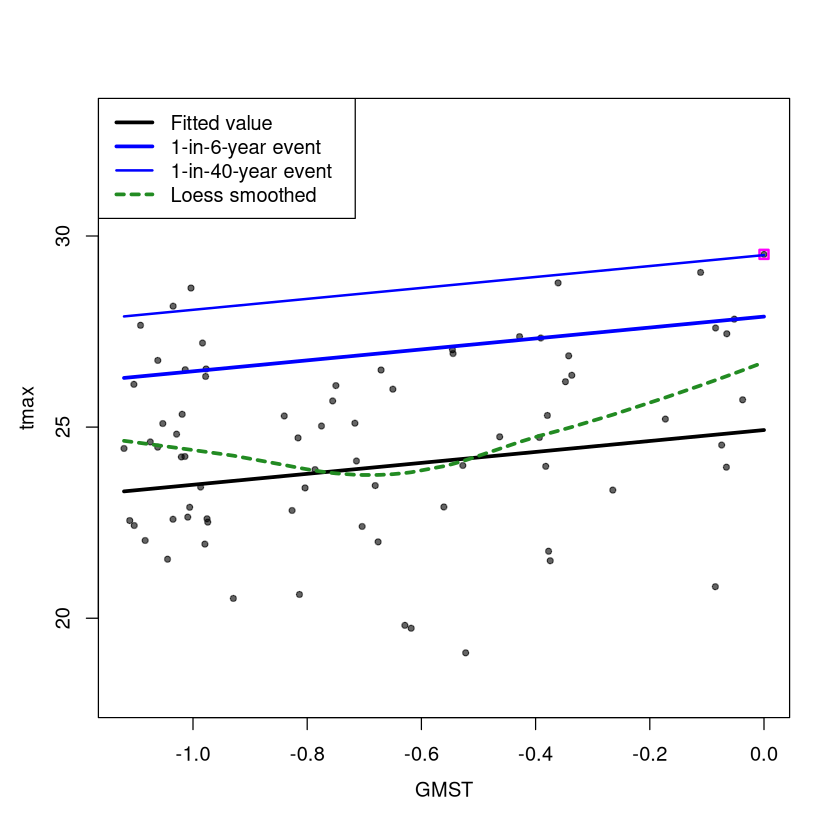

In [31]:
# what does the fitted trend look like vs GMST?
plot_covtrend(mdl, xcov = "gmst", add_loess = T, ylim = c(18,33))

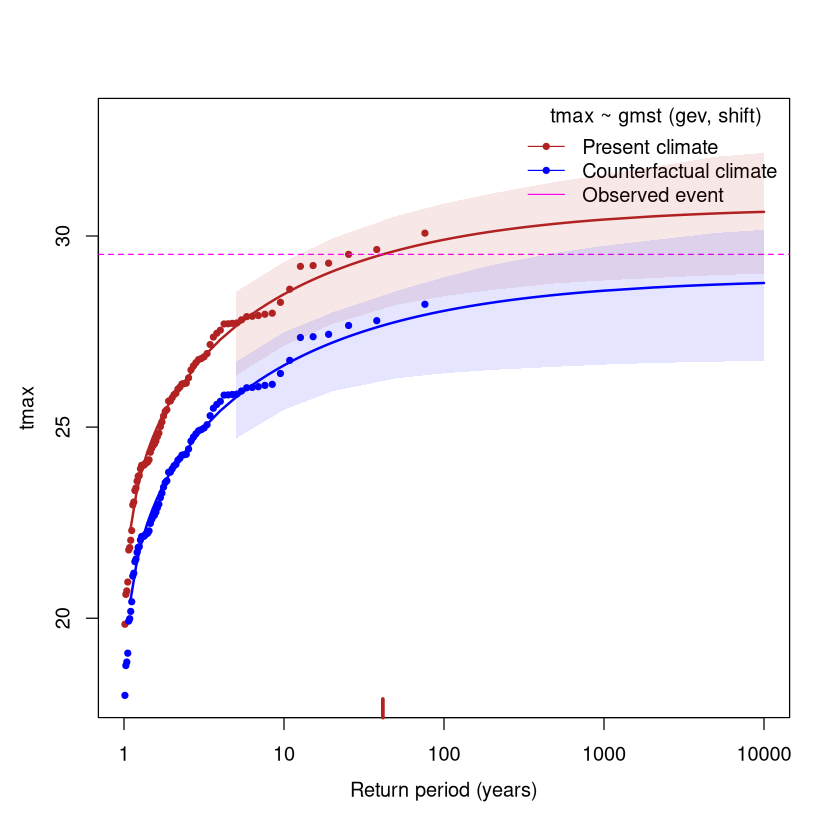

In [32]:
# How well does the model fit the data?
# the points should be close to the line - if they're not within the shaded region, the model is a poor fit
plot_returnlevels(mdl, cov_f = cov_factual, cov_cf = cov_counterfactual, ylim = c(18,33))

# Get the fitted model parameters \& results

The script will estimate both absolute and relative changes in intensity.
- For temperatures / `shift` fit, report **absolute** changes
- For precipitation / `fixeddisp` fit, report **relative** changes

In [ ]:
# use the built-in function to bootstrap the model results
boot_res <- boot_ci(mdl, cov_f = cov_factual, cov_cf = cov_counterfactual)

In [ ]:
# save as a .csv to look at them later
write.csv(boot_res, "res-obs_era5.csv")

# Produce some figures for the report

You can modify the height and width of the figure by changing the height and width of the .png  
To see other plotting options, use eg. `?plot_trend`

In [ ]:
# comment out the top & bottom lines to see what the figures look like before saving them
png("fig_obs-trend_era5.png", height = 480, width = 480); {
    plot_trend(mdl, add_loess = T, ylim = c(18,33), ylab = "Maximum temperature (degC)", lwd = 2)
}; dev.off()

In [ ]:
png("fig_obs-gmsttrend_era5.png", height = 480, width = 480); {
    plot_covtrend(mdl, xcov = "gmst", add_loess = T, ylim = c(18,33), ylab = "Maximum temperature (degC)", lwd = 2)
}; dev.off()

In [ ]:
png("fig_obs-returnlevels_era5.png", height = 480, width = 480); {
    plot_returnlevels(mdl, cov_f = cov_factual, cov_cf = cov_counterfactual, ylim = c(18,33), ylab = "Maximum temperature (degC)",
                     legend_labels = c("2025", "Preindustrial"))
}; dev.off()

# (Optional) Getting the return period of an event

In [25]:
# get the return period of a particular value in a particular climate
return_period(mdl, x = 25, fixed_cov = cov_factual)
return_period(mdl, x = 25, fixed_cov = cov_counterfactual)

[1] 1.61167

[1] 3.1608

# (Not used) Choosing between distributions

This is particularly important when trying to decide whether to include an additional covariate (eg. Nino3.4 index)

In [ ]:
# try fitting different distributions to compare which actually fits better
mdl_gev <- fit_ns(dist = "gev", type = "shift", data = df, varnm = "tmax", covnm = "gmst", lower = F)
mdl_norm <- fit_ns(dist = "norm", type = "shift", data = df, varnm = "tmax", covnm = "gmst", lower = F)

# use AIC to identify the model that fits better (lower score is better)
aic(mdl_gev)
aic(mdl_norm)

# (Not used) Look at the pdf in the factual & counterfactual climates

In [ ]:
# the 'rwwa' package has a built-in function to transform all points into the factual or counterfactual climate
y_factual <- stransform(mdl, fixed_cov = cov_factual)
y_counterfactual <- stransform(mdl, fixed_cov = cov_counterfactual)

# it can also extract the model parameters for a fixed value of the covariates
pars_factual <- ns_pars(mdl, fixed_cov = cov_factual)
pars_counterfactual <- ns_pars(mdl, fixed_cov = cov_counterfactual)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# we can therefore plot the density of the temperatures as they would have been in today's climate, or in the counterfactual climate
par(lwd = 2)
plot(density(y_factual), col = "red3", ylim = c(0,0.175), main = "", xlab = "Maximum temperature (degC)")
lines(x <- seq(15,35,0.1), devd(x, loc = pars_factual$loc, scale = pars_factual$scale, shape = pars_factual$shape),
     type = "l", col = "red3", lty = 2)

lines(density(y_counterfactual), col = "blue2")
lines(x <- seq(15,35,0.1), devd(x, loc = pars_counterfactual$loc, scale = pars_counterfactual$scale, shape = pars_counterfactual$shape),
     type = "l", col = "blue2", lty = 2)

# add ticks to show temperatures that were actually observed
rug(df$tmax, lwd = 3)